In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PyPDF2
import collections
from collections import Counter
import operator
import re

In [2]:
def filter_pnovo_Sequences (df, score, seq_len=3):
    filtered_df=df.loc[(df['Score']>score) & (df['sequence_length']>seq_len)]
    sequences=filtered_df['Sq']
    return sequences

def extract_words(dictionary, sequences):
    all_words=[]
    for j in sequences:

        words_extracted=[]
        for i in dictionary:
            if str(i) in j.lower():
                words_extracted.append(i)
        all_words.append(words_extracted)
    return all_words

def replace_variants (sequence_list):
    sequence_list_o=[i.replace('K', 'O') for i in sequence_list]
    sequence_list_o=[i for i in sequence_list_o if 'O' in i]
    sequence_list_u=[i.replace('K', 'U') for i in sequence_list]
    sequence_list_u=[i for i in sequence_list_u if 'U' in i]
    sequence_list_i=[i.replace('L', 'I') for i in sequence_list]
    sequence_list_i=[i for i in sequence_list_i if 'I' in i]
    sequence_list_none = [i for i in sequence_list if 'K' not in i]
    sequence_all=sequence_list_none+sequence_list_o+sequence_list_u+sequence_list_i
    #sequence_all.append(sequence_list)
    sequence_all_reverse=[i[::-1] for i in sequence_all]
    
    sequences=[sequence_all, sequence_all_reverse]
    return(sequences)

def words_cut_dict (dictionary, letter):
    words_letter=[i for i in dictionary if letter in str(i)]
    words_letter_before=[i.split(letter)[0] + letter for i in words_letter]
    words_letter_after=[i.split(letter)[1] for i in words_letter]
    dict_before=dict(zip(words_letter_before, words_letter))
    dict_after=dict(zip(words_letter_after, words_letter))
    dict_before.update(dict_after)
    return dict_before

def return_word_dict (dictionary, sequences, str_len, dict_complete):   
    words_extracted=extract_words(dictionary, sequences)
    all_words=[]
    #all_words_complete=[]
    for lists in words_extracted:
        for item in lists:
            all_words.append(item)
            #all_words_complete.append(dict_complete[item]) 
    from collections import Counter
    count= dict(Counter([i for i in all_words if len(str(i))>str_len]))
    x = count
    sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
    c_words=[]
    for i in np.arange(len(sorted_x)):
        c_words.append(sorted_x[i][0])
    c_words_complete=[]
    for j in c_words:
        c_words_complete.append(dict_complete[j])
    fun=dict(zip(c_words_complete, sorted_x))
    return fun

In [3]:
## de novo result from pNovo
file = 'selected_result.txt'
df_Sq_hcd = pd.read_csv(file, sep='\t')
sequence_length = [len(str(i)) for i in list(df_Sq_hcd.Sq)]
df_Sq_hcd['sequence_length']=sequence_length

file='selected_result_ETD_DE.txt'
df_pnovo_ETD_DE=pd.read_csv(file, sep='\t')
sequence_length=[len(str(i)) for i in list(df_pnovo_ETD_DE.Sq)]
df_pnovo_ETD_DE['sequence_length']=sequence_length

file='selected_lumos_cid.txt'
df_pnovo_cid=pd.read_csv(file, sep='\t')
sequence_length=[len(str(i)) for i in list(df_pnovo_cid.Sq)]
df_pnovo_cid['sequence_length']=sequence_length

file='selected_lumos_HCD.txt'
df_lumos_hcd=pd.read_csv(file, sep='\t')
sequence_length=[len(str(i)) for i in list(df_lumos_hcd.Sq)]
df_lumos_hcd['sequence_length']=sequence_length

## de novo result from PEAKS
df_PEAKS=pd.read_csv('de novo peptides_peaks_qe.csv')

/Users/niulili/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Dictionary: Molecular Biology + Google 10k most commonly used words

In [4]:
%%time
# Molecular Biology (5th edition) by Robert F. Weaver downloaded from:
# https://www.pdfdrive.com/molecular-biology-5th-ed-e14980853.html

pdf_file = open('molecular_biology_r-_f-_weaver_5th_ed.pdf', 'rb')
read_pdf = PyPDF2.PdfFileReader(pdf_file)
number_of_pages = read_pdf.getNumPages()
c = collections.Counter(range(number_of_pages))
book=''
for i in c:
    page = read_pdf.getPage(i)
    page_content = page.extractText()
    book=book+page_content

result=book
punctuations=['\n', '/', '.', ',',' ', '(', ')', ':', '?', '[', ']', ';', '“', '”', '_']
for i in punctuations:
    result=result.replace(i, ' ')
result=result.replace('–', '')
result=result.replace('-', '')
result=result.split(' ')
result=[j for j in result if len(j) > 1]

result_dict=Counter([i for i in result])
sorted_result = sorted(result_dict.items(), key=operator.itemgetter(1), reverse=True)
#words_MB=[i[0] for i in sorted_result]
#len(words_MB)

CPU times: user 2min 19s, sys: 932 ms, total: 2min 19s
Wall time: 2min 21s


In [5]:
df_MB=pd.DataFrame(sorted_result)
df_MB.columns=('words', 'occurence')
df_MB.to_csv('words_MB.csv')
df_MB.shape

(32213, 2)

In [6]:
## google 10k most common words downloaded from https://github.com/first20hours/google-10000-english

df_10k = pd.read_csv('10kwords.txt', sep='\t')
df_10k.columns=['words']
words_10k=list(df_10k.words)
words_10k=[i for i in words_10k if len(str(i))>1]

words_MB=list(df_MB['words'])
words_combined=list(set(words_10k+words_MB))

In [7]:
path ='/Users/niulili/Dropbox/PythonCourse2018/Impractical Python projects/12dicts-6/American'
file = path+'/2of4brif.txt'

with open(file) as in_file:
    word_list = in_file.read().strip().split('\n')
words_60k=word_list

In [8]:
len(list(set(words_MB) & set(words_10k)))

4345

In [9]:
for i in [words_10k, words_MB, words_combined]:
    print(len(i))

9870
32213
37738


In [10]:
df_MB[df_MB['words']=='colleagues']

,words,occurence
68,colleagues,948


#### prepare a dictionary that takes care of words cut in the middle e.g. WK_NDER_ED

In [11]:
dictionary=words_combined
dict_r=words_cut_dict(dictionary, 'r')
dict_o=words_cut_dict(dictionary, 'o')
dict_u=words_cut_dict(dictionary, 'u')
dict_variant=dict_r.copy()
dict_variant.update(dict_o)
dict_variant.update(dict_u)

dict_complete=dict(zip(dictionary, dictionary))

dict_all=dict_variant.copy()
dict_all.update(dict_complete)

print(len(dict_complete))
print(len(dict_variant))
print(len(dict_all))

words_all = list(dict_all.keys())

37738
22443
56930


### Peptide sequences extracted from pNovo result

In [12]:
df_Sq=df_Sq_hcd
filtered_Sq = df_Sq.loc[(df_Sq['Score']>30) & (df_Sq['sequence_length']>3)]
sequences_pnovo = filtered_Sq['Sq']
print(len(filtered_Sq))
filtered_Sq.head()

24764


,#,Title,Charge,Sq,Mod_Sites,Score,Spectra Mass,Delta Mass,Delta Mass (PPM),AA Score,sequence_length
0,89405,E:\YPIC\20181126_QE10_nLC14_LiNi_SA_Fun_01.raw,2,NDAMENTALLLMRTATLGKNSLNLLFEAR,"13,Arg->Orn[R];",114.797324,1995.023724,-0.011826,-5.93,NaN,29
1,6898,E:\YPIC\20181126_QE10_nLC14_LiNi_SA_Fun_01.raw,2,TAVGPLSVALDQHESFLFYK,NaN,102.795096,1995.023724,-0.006495,-3.26,NaN,20
2,33908,E:\YPIC\20181126_QE10_nLC14_LiNi_SA_Fun_01.raw,2,QDALNAVEQHGLVFLDELDK,"5,Label_15N(2)[N];",98.992700,1995.023724,-0.006890,-3.45,NaN,20
3,26832,E:\YPIC\20181126_QE10_nLC14_LiNi_SA_Fun_01.raw,2,TYAATSDFTLLMFKHANPAFNLFWAGWDR,NaN,98.770167,1995.023724,-0.004901,-2.46,NaN,29
4,24891,E:\YPIC\20181126_QE10_nLC14_LiNi_SA_Fun_01.raw,2,TLHVVAQVADVLQQQSLHVR,NaN,98.187362,1995.023724,-0.000488,-0.24,NaN,20


In [13]:
len(filtered_Sq)

24764

#### replace 'K' to 'O' and 'U', 'L' to 'I'

In [14]:
sequences_pnovo_all=replace_variants(sequences_pnovo)[0]
len(sequences_pnovo_all)

58596

### Peptide sequences extracted from pNovo result_2

In [15]:
def filter_pnovo_Sequences (df, score, seq_len=3):
    filtered_df=df.loc[(df['Score']>score) & (df['sequence_length']>seq_len)]
    sequences=filtered_df['Sq']
    return sequences

In [16]:
sequences_etd_pnovo=filter_pnovo_Sequences(df_pnovo_ETD_DE, score=10)

#### replace 'K' to 'O' and 'U', 'L' to 'I'

In [17]:
sequences_etd_pnovo_all=replace_variants(sequences_etd_pnovo)[0]
len(sequences_etd_pnovo_all)

17914

### Peptide sequences extracted from pNovo result_3

In [18]:
sequences_cid_pnovo=filter_pnovo_Sequences(df_pnovo_cid, score=10)

In [19]:
sequences_cid_pnovo_all=replace_variants(sequences_cid_pnovo)[0]
len(sequences_cid_pnovo_all)

58176

### Peptide sequences extracted from PEAKS result

In [20]:
def filter_peaks_sequences (df):
    """To process de novo output from PEAKS and apply filter"""
    df_filter = df[(df.Area >10e4) &(abs(df.ppm < 5)) & (df['ALC (%)'] > 60)]
    peptides = df_filter['Peptide']
    
    sequences = []
    for i in peptides:
        new_i = re.sub("[\(\[].*?[\)\]]", "", i)
        sequences.append(new_i)
    
    sequences_all = replace_variants(sequences)[0]
    return sequences_all

In [27]:
sequences_peaks = filter_peaks_sequences(df_PEAKS)
len(sequences_peaks)

27176

### dictionary search 

In [30]:
%%time

dictionary=words_all
sequences=sequences_pnovo_all
dict_complete=dict_all
afun=return_word_dict(dictionary, sequences, 2, dict_complete)

possible=pd.DataFrame(afun).transpose().reset_index()
possible.columns=['word','fragment', 'occurence']
evidence_letters=[len(str(i)) for i in list(possible['fragment'])]
possible['identified_letters']=evidence_letters
aa=possible[(possible['identified_letters']>2)&(possible['occurence']>1)].sort_values('occurence', ascending=False)
#aa.to_csv('Supple_1.csv')
aa[aa['identified_letters']>4]

CPU times: user 18min 22s, sys: 1.92 s, total: 18min 24s
Wall time: 38min 33s


In [31]:
aa[aa['identified_letters']>4][:20]

,word,fragment,occurence,identified_letters
251,mental,mental,167,6
406,tournament,nament,112,6
467,theta,theta,99,5
509,ultracentrifuged,acent,87,5
575,prescan,escan,73,5
707,dered,dered,57,5
887,fundamental,ndamental,39,9
1066,allel,allel,28,5
1385,collectors,llect,14,5
1408,somewhat,mewhat,14,6


#### Plot

In [32]:
peptides= [23, 351, 3253]
proteins= [1, 35, 555]

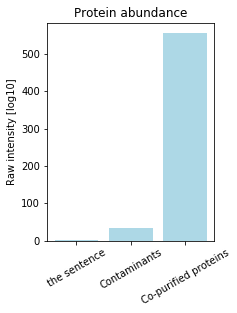

In [33]:
fig, ax=plt.subplots(figsize=(3,4))
plt.bar(x=[1,2,3], height=proteins, color='lightblue')
plt.xticks(range(1, 4), ('the sentence', 'Contaminants', 'Co-purified proteins'), rotation=30)
plt.title('Protein abundance')
plt.ylabel('Raw intensity [log10]')
plt.savefig('protein abundance.pdf', bbox_inches='tight')
plt.show()
